## Dataset Direct Download Urls

- [Deep fashion introduction paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf)


In [ ]:
'''
References

- https://github.com/open-mmlab/mmfashion/tree/ca8d039fcfa3f88f68f0c6ce218da7290b03d433
- https://blog.floydhub.com/similar-fashion-images/
- https://github.com/open-mmlab/mmfashion/blob/master/docs/DATA_PREPARATION.md
- https://github.com/wenxinxu/deep-shopping

Post of interest.
- https://towardsdatascience.com/implementing-a-resnet-model-from-scratch-971be7193718
- https://github.com/deep-diver/CIFAR10-img-classification-tensorflow
'''
print()

## Step 1 - Dataset Utilities and Preprocessing

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 


from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions


from tqdm import tqdm_notebook
from tqdm import tqdm
from scipy.spatial.distance import hamming, cosine
from timeit import default_timer as timer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
def get_top_categories_list():
    list_category_cloth = 'dataset/Anno/list_category_cloth.txt'
    '''
    Return list containing top category from list_category_cloth.txt
    '''
    with open(list_category_cloth, 'r') as f:
        top_categories = f.readlines()[2:]
    return [line.split(' ')[0] for line in top_categories if len(line)>0 and line[-2]=='1']

In [22]:
categories_for_tops = get_top_categories_list()

#select desired categories from top
categories_for_tops = ['Anorak',
 'Blouse',
 'Bomber',
 'Cardigan',
 'Jacket',
 'Parka',
 'Sweater',
 'Tank',
 'Tee']

In [23]:
PREFIX = 'dataset/modified_dataset'

def split_img():
    '''
    Creates list_eval_partition for items which are tops and saves them in dataset/modified_dataset/<evaluation_status> directory
    where evaluation_status = train | test | val
    '''    
    rf = open('dataset/Eval/list_eval_partition.txt').readlines()
    wf1 = open(os.path.join(PREFIX, 'train', 'list_eval_partition_train.txt'), 'w')
    wf2 = open(os.path.join(PREFIX, 'test', 'list_eval_partition_test.txt'), 'w')
    wf3 = open(os.path.join(PREFIX, 'val', 'list_eval_partition_val.txt'), 'w')

    for i, line in enumerate(rf[2:]):
        aline = line.strip('\n').split()
        imgname, prefix = aline[0], aline[1]
        
        item_is_top = False
        category = imgname.split('/')[1].split('_')[-1]
        if category in categories_for_tops:
            item_is_top = True
        
        if item_is_top:
            if prefix == 'train':
                wf1.write('%s\n' % imgname)
            elif prefix == 'test':
                wf2.write('%s\n' % imgname)
            else:
                wf3.write('%s\n' % imgname)

    wf1.close()
    wf2.close()
    wf3.close()

def split_attribute(train_img, test_img, val_img):
    
    rf = open('dataset/Anno/list_attr_img.txt').readlines()
    wf1 = open(os.path.join(PREFIX,'train', 'train_attr.txt'), 'w')
    wf2 = open(os.path.join(PREFIX,'test', 'test_attr.txt'), 'w')
    wf3 = open(os.path.join(PREFIX,'val', 'val_attr.txt'), 'w')

    def sort_attr():
        d = dict()
        for i, line in enumerate(rf[2:]):
            aline = line.strip('\n').split()
            imgname = aline[0]
            d[imgname] = []
            attrs = aline[1:]
            for ai, a in enumerate(attrs):
                if int(a) <= 0:
                    d[imgname].append(0)
                else:
                    d[imgname].append(int(a))
        return d

    attributes = sort_attr()
    #print(attributes)

    def write_attr(imgs, wf):
        for i, line in enumerate(imgs):
            imgname = line.strip('\n')
            attr = attributes[imgname]
            for a in attr:
                wf.write('%s ' % str(a))
            wf.write('\n')
        wf.close()

    write_attr(train_img, wf1)
    write_attr(test_img, wf2)
    write_attr(val_img, wf3)

def split_category(train_img, test_img, val_img):
    wf1 = open(os.path.join(PREFIX,'train', 'train_cate.txt'), 'w')
    wf2 = open(os.path.join(PREFIX,'test', 'test_cate.txt'), 'w')
    wf3 = open(os.path.join(PREFIX,'val', 'val_cate.txt'), 'w')

    def gather_cate():
        d = dict()
        rf = open('dataset/Anno/list_category_img.txt').readlines()
        for i, line in enumerate(rf[2:]):
            aline = line.strip('\n').split()
            imgname, cate = aline[0], aline[1]
            d[imgname] = cate

        return d

    img2cate = gather_cate()

    def write_cate(imgs, wf):
        # cate_ids = []
        for i, line in enumerate(imgs):
            imgname = line.strip('\n').split()[0]
            cate_id = int(img2cate[imgname])
            # cate_ids.append(cate_id)
            wf.write('%d\n' % cate_id)

    write_cate(train_img, wf1)
    write_cate(test_img, wf2)
    write_cate(val_img, wf3)


def split_bbox(train_img, test_img, val_img):
    rf = open('dataset/Anno/list_bbox.txt').readlines()
    wf1 = open(os.path.join(PREFIX,'train', 'train_bbox.txt'), 'w')
    wf2 = open(os.path.join(PREFIX,'test', 'test_bbox.txt'), 'w')
    wf3 = open(os.path.join(PREFIX,'val', 'val_bbox.txt'), 'w')

    def sort_bbox():
        d = dict()
        for i, line in enumerate(rf[2:]):
            aline = line.strip('\n').split()
            imgname = aline[0]
            d[imgname] = []
            bbox = aline[1:]
            for bi, b in enumerate(bbox):
                d[imgname].append(int(b))
        return d

    bboxes = sort_bbox()

    def write_bbox(imgs, wf):
        for i, line in enumerate(imgs):
            imgname = line.strip('\n')
            bbox = bboxes[imgname]
            for b in bbox:
                wf.write('%s ' % str(b))
            wf.write('\n')
        wf.close()

    write_bbox(train_img, wf1)
    write_bbox(test_img, wf2)
    write_bbox(val_img, wf3)

def split_lms(train_img, test_img, val_img):
    rf = open('dataset/Anno/list_landmarks.txt').readlines()
    wf1 = open(os.path.join(PREFIX, 'train', 'train_landmarks.txt'), 'w')
    wf2 = open(os.path.join(PREFIX,'test', 'test_landmarks.txt'), 'w')
    wf3 = open(os.path.join(PREFIX, 'val', 'val_landmarks.txt'), 'w')

    def sort_lm():
        d = dict()
        for i, line in enumerate(rf[2:]):
            aline = line.strip('\n').split()
            imgname = aline[0]
            d[imgname] = []
            lms = aline[2:]
            for li, lm in enumerate(lms):
                if li % 3 == 0:
                    continue
                else:
                    d[imgname].append(int(lm))
        return d

    landmarks = sort_lm()

    def write_lm(imgs, wf):
        for i, line in enumerate(imgs):
            imgname = line.strip('\n')
            lm = landmarks[imgname]
            for a in lm:
                wf.write('%s ' % str(a))

            num_lm = len(lm)
            if num_lm < 16:
                for cnt in range(16 - num_lm):
                    wf.write('0 ')
            wf.write('\n')
        wf.close()

    write_lm(train_img, wf1)
    write_lm(test_img, wf2)
    write_lm(val_img, wf3)
def split_category(train_img, test_img, val_img):
    wf1 = open(os.path.join(PREFIX,'train', 'train_cate.txt'), 'w')
    wf2 = open(os.path.join(PREFIX,'test', 'test_cate.txt'), 'w')
    wf3 = open(os.path.join(PREFIX,'val', 'val_cate.txt'), 'w')

    def gather_cate():
        d = dict()
        rf = open('dataset/Anno/list_category_img.txt').readlines()
        for i, line in enumerate(rf[2:]):
            aline = line.strip('\n').split()
            imgname, cate = aline[0], aline[1]
            d[imgname] = cate

        return d

    img2cate = gather_cate()

    def write_cate(imgs, wf):
        # cate_ids = []
        for i, line in enumerate(imgs):
            imgname = line.strip('\n').split()[0]
            cate_id = int(img2cate[imgname])
            # cate_ids.append(cate_id)
            wf.write('%d\n' % cate_id)

    write_cate(train_img, wf1)
    write_cate(test_img, wf2)
    write_cate(val_img, wf3)

def remap_categories(train_eval_file, test_eval_file, val_eval_file):
    '''
    Update the category file from format <old category> to format <old category> <new category>
    '''
    new_category_map = {'1':'0','4':'0','11':'0','13':'0', #Anorak, bomber, jacket,parka
                        '6':'1', #Cardigan
                        '16':'2',#sweater
                        '17':'3',#Tank
                        '3':'4',#blouse
                        '18':'5'#Tee
                       }
    #{'8', '10', '9', '7', '15', '12', '20', '4', '14', '5', '19'}
    #{ Halter, hoodie, Henley, Flannel, Poncho, Jersey, Turtleneck, Bomber, Peacoat, Button-Down, Top}
    
    rf1 = open(train_eval_file).readlines()
    wf1 = open(os.path.join(PREFIX,'train', 'new_train_cate.txt'), 'w')
    
    rf2 = open(test_eval_file).readlines()
    wf2 = open(os.path.join(PREFIX,'test', 'new_test_cate.txt'), 'w')
    
    rf3 = open(val_eval_file).readlines()
    wf3 = open(os.path.join(PREFIX,'val', 'new_val_cate.txt'), 'w')
    
    def append_new_category(rf,wf):
        for line in rf:
            aline = line.strip('\n')
            try:
                new_cate = new_category_map[aline]
                line = line.replace('\n', ' '+str(new_cate))
                wf.write('%s\n' % line)
            except:
                pass
    
    #append_new_category(rf1,wf1)
    append_new_category(rf2,wf2)
    #append_new_category(rf3,wf3)
    return

In [24]:
#split_img()
train_img = open(os.path.join(PREFIX, 'train', 'list_eval_partition_train.txt')).readlines()
test_img = open(os.path.join(PREFIX, 'test', 'list_eval_partition_test.txt')).readlines()
val_img = open(os.path.join(PREFIX, 'val', 'list_eval_partition_val.txt')).readlines()
#split_attribute(train_img, test_img, val_img)
#split_category(train_img, test_img, val_img)
#split_bbox(train_img, test_img, val_img)
#split_lms(train_img, test_img, val_img)
#remap_categories('dataset/modified_dataset/train/train_cate.txt','dataset/modified_dataset/test/test_cate.txt', 'dataset/modified_dataset/val/val_cate.txt' )
#(len(train_img),len(test_img), len(val_img))


In [25]:
def image_loader(image_path, image_size, bbox):
    '''
    Function to load image from disk and resize
    :param image_path: path of image from disk
    :param image_size: size of loaded image
    '''

    image,img_crop = None,None
    image = cv2.imread(image_path)
    
    x, y, w, h = bbox[0], bbox[1], bbox[2]+bbox[0], bbox[3]+bbox[1]
    try:
        img_crop = image[y:y+h, x:x+w]
        img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
        img_crop = cv2.resize(img_crop, image_size, cv2.INTER_CUBIC)
        #test
        
        
    except: #if image read fails just return None
        pass
    return img_crop

#bounding box
def get_bbox(bbox_file_path):
    rf = open(bbox_file_path).readlines()
    bboxes = []
    for l in rf:
        x,y,w,h,_ = l.strip('\n').split(' ')
        bbox = (int(x), int(y), int(w), int(h))
        bboxes.append(bbox)
    return bboxes

In [26]:

def data_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle, bbox_file_path=None):
    '''
    Loads images and labels from dataset folder.
    
    :param dataset_path: path to train/test dataset folder
    :param labels_file_path: path to .txt file where classes names are written
    :param image_size: tuple, single image size
    :param image_paths_pickle:n name of pickle file where all image paths will be saved
    '''
    
    with open(labels_file_path, 'r') as f:
        classes = f.read().split('\n')[:-1]
        
    images = [] #array of 32*32 images 
    labels = [] #array of integers denoting index of label in classes array
    image_paths = []# absolute path of image including image name
    
    #bounding boxes processing
    bboxes = get_bbox(bbox_file_path)
    
    img_file = open(dataset_path).readlines()
    lbl_file = open(labels_file_path).readlines()
    
    for line in lbl_file:
        label = line.split(' ')[1].strip('\n')
        labels.append(label)
    
    for idx,line in enumerate(img_file):
        image_name = line.strip('\n')
        image_path = 'dataset/Img/'+ image_name
        image_paths.append(image_path)
        #shrink image
        images.append(image_loader(image_path, image_size, bboxes[idx]))
    
    # Modify list to exclude None images.
    '''
    none=[idx for idx,item in enumerate(images) if  item is None]
    images = list(filter(lambda item: item is not None,images)) #new list
    labels = [item for idx, item in enumerate(labels) if idx not in none]
    image_paths = [item for idx, item in enumerate(image_paths) if idx not in none]
    
    # create pickle file to store image paths
    with open(image_paths_pickle + '.pickle', 'wb') as f:
        pickle.dump(image_paths,f)
    assert(len(images) == len(labels))
    return np.array(images), np.array(labels)
    
    '''
    none=[False if item is None else True for idx,item in enumerate(images) ]
    images = np.array(images)
    labels = np.array(labels)
    images = images[none]
    labels = labels[none]
    
    s =[]
    l=[]
    for i in range(len(images)):
        s.append(images[i])
        l.append(labels[i])
    s = np.array(s)
    l = np.array(l)
    return s,l
    
    '''#recalibrate images and labels
    images=images[not_none_index]
    labels=labels[not_none_index]
    image_paths=image_paths[not_none_index]
    
    # create pickle file to store image paths
    with open(image_paths_pickle + '.pickle', 'wb') as f:
        pickle.dump(image_paths,f)
    assert(len(images) == len(labels))
    return images, labels
    '''

In [ ]:
male =[{},None,3,4,None]
male=np.array(male)

mm = male!=None
bb=np.array([6,7,8,9,10])
mm

## Step 2: Similarity calculation

In [28]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
    '''
    Calculates cosine distance between query image and all training set images
    
    :param training_set_vectors: numpy matrix
    :param query_vector: numpy vector
    :param top_n: integer
    '''
    distances = []
    
    for training_vector in training_set_vectors:
        distances.append(cosine(training_vector, query_vector[0]))
    return np.argsort(distances)[:top_n]

def hamming_distance(training_set_vectors, query_vector, top_n=50):
    '''
    Calculates hamming distance between query image and all training set images
    
    :param training_set_vectors: numpy matrix
    :param query_vector: numpy vector
    :param top_n: integer
    '''
    distances = []
    
    for training_vector in training_set_vectors:
        distances.append(hamming(training_vector, query_vector[0]))
    return np.argsort(distances)[:top_n]

def sparse_acccuracy(true_labels, predicted_labels):
    '''
    Uses softmax output to calculate accuracy of model
    
    :param true_labels: array of real label ['4','4','4']
    :param predicted_labels: matrix, each index contains an array with probablilties for corresponding label value [[0,0,0,1]]
    '''
    assert(len(true_labels) == len(predicted_labels))
    
    correct = 0
    #print(true_labels)
    #print(np.argmax(predicted_labels, axis=1))
    for idx in range(len(true_labels)):
        if np.argmax(predicted_labels[idx]) == true_labels[idx]:
            correct+=1
    #print(correct/len(true_labels))
    return correct/len(true_labels)


## Step 3: Model Utilities

In [29]:
def model_inputs(image_size):
    '''
    Defines CNN inputs(placeholders)
    
    :param image_size: tuple, (height, width) of an image
    '''
    inputs = tf.placeholder(dtype= tf.float32, shape=[None,image_size[0], image_size[1],3], name='images')
    targets = tf.placeholder(dtype=tf.int32, shape=[None], name='targets')
    dropout_rate = tf.placeholder(dtype=tf.float32, name='dropout_rates')
    
    return inputs, targets, dropout_rate

In [5]:
def conv_block(inputs,
              number_of_filters,
              kernel_size,
              strides=(1,1),
              padding='SAME',
              activation=tf.nn.relu,
              max_pool=True,
              batch_norm=True):
    '''
    Defines convolutional block layer
    
    :param inputs: data from previous layer
    :param number_of_filters: integer, number of conv filters 
    :param kernel_size: tuple, size of conv layer kernel
    :param padding: string, type of padding technique: SAME or VALID
    :param activation: tf.object, activation function used on the layer
    :param max_pool: boolean, if true the conv block will use max_pool
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    conv_features = layer = tf.layers.conv2d(inputs=inputs,
                                            filters=number_of_filters,
                                            kernel_size=kernel_size,
                                            strides=strides,
                                            padding=padding,
                                            activation=activation)
    
    if max_pool:
        layer = tf.layers.max_pooling2d(layer,
                                       pool_size=(2,2),
                                       strides=(2,2),
                                       padding='SAME')
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
    return layer, conv_features

def dense_block(inputs,
               units,
               activation = tf.nn.relu,
               dropout_rate=None,
               batch_norm=True):
    '''
    Defines a dense block layer
    
    :Param inputs: data from a previous layer
    :Param units: integer, number of neurons/units for a dense layer
    :Param activation: tf,ibject, activation function used on the layer
    :Param dropout_rate: dropout rate used in this dense block
    :Param batch_norm: boolean, if true the conc block will use batch normalization
    '''
    
    dense_features = layer = tf.layers.dense(inputs=inputs,
                                            units=units,
                                            activation=activation)
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer,
                                 rate=dropout_rate)
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
    return layer, dense_features

def opt_loss(logits,
            targets,
            learning_rate):
    '''
    Defines model's loss function and optimizer
    
    :param logits: pre-activated model outputs
    :param targets: true labels for each input sample
    :param learning_rate: learning rate
    '''
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    optimizer = None
    if learning_rate != 0:
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return loss, optimizer

In [6]:
class ImageSearchModel(object):
    
    def __init__(self ,
                learning_rate,
                image_size,
                number_of_classes=6):
        '''
        Defines CNN model.
        
        :param learning_rate: learning_rate
        :param image_size: tuple, (height, width) of an image
        :param number_of_classes: integer, number of classes in a dataset.
        '''
        
        tf.reset_default_graph()
        
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf.layers.batch_normalization(self.inputs)
        
        #conv block 1
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images,
                                                       number_of_filters =64,#6 ->2
                                                       kernel_size=(3,3),
                                                       strides=(1,1),
                                                       padding='SAME',
                                                       activation=tf.nn.relu,
                                                       max_pool=True,
                                                       batch_norm=True)
        #conv block 2
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1,
                                                       number_of_filters =128,#7->3
                                                       kernel_size=(3,3),
                                                       strides=(1,1),
                                                       padding='SAME',
                                                       activation=tf.nn.relu,
                                                       max_pool=True,
                                                       batch_norm=True)
        
        #conv block 3
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2,
                                                       number_of_filters =256,#8 ->4
                                                       kernel_size=(5,5),
                                                       strides=(1,1),
                                                       padding='SAME',
                                                       activation=tf.nn.relu,
                                                       max_pool=True,
                                                       batch_norm=True)
        #conv block 4
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3,
                                                       number_of_filters =512,#9 ->5
                                                       kernel_size=(5,5),
                                                       strides=(1,1),
                                                       padding='SAME',
                                                       activation=tf.nn.relu,
                                                       max_pool=True,
                                                       batch_norm=True)
        #flattening
        flat_layer = tf.layers.flatten(conv_block_4)
        
        #Dense block 1
        dense_block_1, dense_1_features = dense_block(flat_layer,
                                                     units=128,#7 ->3
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        
        #Dense block 2
        dense_block_2, self.dense_2_features = dense_block(dense_block_1,
                                                     units=256,#8 ->4
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        #Dense block 3
        dense_block_3, self.dense_3_features = dense_block(dense_block_2,
                                                     units=512,#9 ->5
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        
        #Dense block 4
        dense_block_4, self.dense_4_features = dense_block(dense_block_3,
                                                     units=1024,#10 ->6
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        logits = tf.layers.dense(inputs=dense_block_4,
                                units=number_of_classes,
                                activation=None)
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.opt = opt_loss(logits=logits,
                                      targets=self.targets,
                                      learning_rate=learning_rate)

In [13]:
model = ImageSearchModel(0.001,(32,32), 6)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


## Step 4 Training loop

In [7]:
def train(model,
         epochs,
         drop_rate,
         batch_size,
         data,
         save_dir,
         saver_delta=0.15):
    '''
    Core training function, use this to train model.
    :param model: CNN model
    :param epochs: integer, number of epochs
    :param drop_rate: float, dropout_rate
    :param batch_size: integer, number of samples to put through the model at once
    :param data: tuple, train-test data Example(X_train, y_train, X_test, y_test)
    :param save_dir: string, path to a folder where model checkpoints will be saved
    :param saver_delta: float, used to prevent overfitted model to be saved
    '''
    
    X_train, y_train, X_test, y_test = data
    
    #session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    #Define saver
    saver = tf.train.Saver()
    
    best_test_accuracy = 0
    plot_train_loss = []
    plot_train_accuracy = []
    plot_test_accuracy = []
    
    #Training loop
    for epoch in range(1,epochs+1):
        
        train_accuracy = []
        train_loss = []
        test_loss = []
        
        for ii in tqdm_notebook(range(len(X_train)//batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]
            
            feed_dict = {
                model.inputs: X_batch,
                model.targets: y_batch,
                model.dropout_rate:drop_rate
            }
            
            _, t_loss, preds_t = session.run([model.opt, model.loss, model.predictions], feed_dict=feed_dict)
            
            train_accuracy.append(sparse_acccuracy(y_batch, preds_t))
            train_loss.append(t_loss)
        
        
        print("Epoch: {}/{}".format(epoch, epochs),
             " | Training accuracy: {}".format(np.mean(train_accuracy)),
             " | Training Loss: {}".format(np.mean(train_loss)))
        
        plot_train_loss.append(np.mean(train_loss))
        plot_train_accuracy.append(np.mean(train_accuracy))
        
        test_accuracy = []
        
        for ii in tqdm_notebook(range(len(X_test)//batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_test[start_id:end_id]
            y_batch = y_test[start_id:end_id]
            
            feed_dict = {
                model.inputs: X_batch,
                model.dropout_rate:0.0
            }
            
            preds_test = session.run(model.predictions, feed_dict=feed_dict)
            test_accuracy.append(sparse_acccuracy(y_batch, preds_test))
            t_loss,_ = opt_loss(logits=preds_test, targets=y_batch,learning_rate=0)
            #test_loss.append(t_loss)
        print("Test accuracy: {}".format(np.mean(test_accuracy)))
        #print("Test loss: {}".format(test_loss))
        plot_test_accuracy.append(np.mean(test_accuracy))
        
        #saving the model
        if np.mean(train_accuracy) > np.mean(test_accuracy):
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <=saver_delta:
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    saver.save(session, '{}/model_epoch_{}.ckpt'.format(save_dir, epoch))
    session.close()
    
    plt.plot(plot_train_accuracy, label='training accuracy')
    plt.plot(plot_test_accuracy, label='test accuracy')
    plt.xlabel('# epoch')
    plt.ylabel('accuracy value')
    plt.legend()
    plt.show()

## Setting up hyperparameters and training the model

In [ ]:
start = timer()
X_t, y_t = data_preprocessing(
'dataset/modified_dataset/train/list_eval_partition_train.txt',
'dataset/modified_dataset/train/new_train_cate.txt',
(224,224),
'train_images_pickle',
'dataset/modified_dataset/train/train_bbox.txt')
end = timer()
print(end - start)

In [17]:
start = timer()
X_test, y_test = data_preprocessing(
'dataset/modified_dataset/test/list_eval_partition_test.txt',
'dataset/modified_dataset/test/new_test_cate.txt',
(32,32),
'test_images_pickle',
'dataset/modified_dataset/test/test_bbox.txt')
end = timer()
print(end - start) 

117.1626374519999


In [18]:
start = timer()
X_val, y_val = data_preprocessing(
'dataset/modified_dataset/val/list_eval_partition_val.txt',
'dataset/modified_dataset/val/new_val_cate.txt',
(32,32),
'val_images_pickle',
'dataset/modified_dataset/val/val_bbox.txt')
end = timer()
print(end - start) 

116.91675237799996


In [19]:
np.save('dataset/modified_dataset/test/X_test', X_test)
np.save('dataset/modified_dataset/test/y_test', y_test)

In [42]:
X_val.shape

(9696, 32, 32, 3)

In [22]:
new_X_train = np.concatenate((X_t,X_val))
new_y_train = np.concatenate((y_t,y_val))

### Downsample training class

In [23]:
#img = cv2.imread(dataset_path + 'img/Boxy_Open-Knit_Top/img_00000007.jpg')
new_category_map = {'1':'0','4':'0','11':'0','13':'0', #Anorak, bomber, jacket,parka
                    '6':'1', #Cardigan
                    '16':'2',#sweater
                    '17':'3',#Tank
                    '3':'4',#blouse
                    '18':'5'#Tee
                   }
#{'8', '10', '9', '7', '15', '12', '20', '4', '14', '5', '19'}
#{ Halter, hoodie, Henley, Flannel, Poncho, Jersey, Turtleneck, Bomber, Peacoat, Button-Down, Top}
print()

In [17]:
#create mask of max images per class and apply to training data
n = 6500
mask = np.hstack([np.random.choice(np.where(new_y_train == l)[0], n, replace=False) for l in np.unique(new_y_train)])

NameError: name 'new_y_train' is not defined

In [18]:
new_images_masked = new_X_train[mask]
new_labels_masked = new_y_train[mask]

NameError: name 'new_X_train' is not defined

In [28]:
#create mask of max images per class and apply to test data
n2 = 900
mask2 = np.hstack([np.random.choice(np.where(y_test == l)[0], n2, replace=False) for l in np.unique(y_test)])

In [29]:
len(mask2)

5400

In [30]:
new_test_images_masked = X_test[mask2]
new_test_labels_masked = y_test[mask2]

In [31]:
new_test_images_masked[new_test_labels_masked=='4'].shape

(900, 32, 32, 3)

In [33]:
#nx_train,ny_train = data_preprocessing('../sb/cifar/train/','../sb/cifar/labels.txt', (32,32), 'training_images_pickle')

In [34]:
#nx_test,ny_test = data_preprocessing('../sb/cifar/train/','../sb/cifar/labels.txt', (32,32), 'test_images_pickle')

## Shuffle data to redistribute classes

In [51]:
from sklearn.utils import shuffle

new_labels_masked = new_labels_masked.astype(np.int)
new_test_labels_masked = new_test_labels_masked.astype(np.int)

new_images_masked, new_labels_masked = shuffle(new_images_masked, new_labels_masked)
new_test_images_masked, new_test_labels_masked = shuffle(new_test_images_masked, new_test_labels_masked)

new_images_masked, new_labels_masked = shuffle(new_images_masked, new_labels_masked)
new_test_images_masked, new_test_labels_masked = shuffle(new_test_images_masked, new_test_labels_masked)

In [56]:
new_images_masked = new_images_masked/255.0
np.save('dataset/modified_dataset/train/X_train', new_images_masked)
np.save('dataset/modified_dataset/train/y_train', new_labels_masked)

In [57]:
new_test_images_masked = new_test_images_masked/255.0
np.save('dataset/modified_dataset/test/X_test', new_test_images_masked)
np.save('dataset/modified_dataset/test/y_test', new_test_labels_masked)

## Load dataset from npy file

In [8]:
new_images_masked = np.load('dataset/modified_dataset/train/X_train.npy')
new_labels_masked = np.load('dataset/modified_dataset/train/y_train.npy')

new_test_images_masked = np.load('dataset/modified_dataset/test/X_test.npy')
new_test_labels_masked = np.load('dataset/modified_dataset/test/y_test.npy')

# merge and reshuffle using keras model

In [9]:
new_X = np.concatenate((new_images_masked,new_test_images_masked))
new_y = np.concatenate((new_labels_masked,new_test_labels_masked))

In [17]:
# helper
def y2indicator(Y):
    N = len(Y)
    K = len(set(Y))
    I = np.zeros((N, K))
    I[np.arange(N), Y] = 1
    return I

In [20]:
new_y=y2indicator(new_y)

In [16]:
from keras.models import Sequential,  Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [17]:
'''
K = 6
# make the CNN using KEras functional API
i = Input(shape=(32, 32, 3))
x = Conv2D(filters=32, kernel_size=(3, 3))(i)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=64, kernel_size=(3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(units=100)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=K)(x)
x = Activation('softmax')(x)

model = Model(inputs=i, outputs=x)


# list of losses: https://keras.io/losses/
# list of optimizers: https://keras.io/optimizers/
# list of metrics: https://keras.io/metrics/
a

# note: multiple ways to choose a backend
# either theano, tensorflow, or cntk
# https://keras.io/backend/
'''
print()

In [10]:
model = VGG16(include_top=True, weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 16s 0us/step


In [17]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [19]:
# gives us back a <keras.callbacks.History object at 0x112e61a90>
r = model.fit(new_X, new_y, validation_split=0.33, epochs=10, batch_size=256)
print("Returned:", r)

ValueError: Error when checking input: expected input_1 to have shape (224, 224, 3) but got array with shape (32, 32, 3)

In [28]:
print(r.history.keys())

dict_keys(['accuracy', 'val_loss', 'val_accuracy', 'loss'])


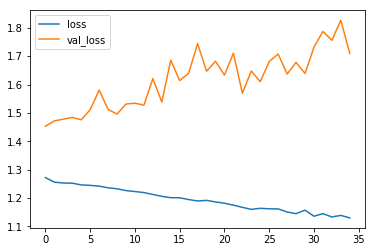

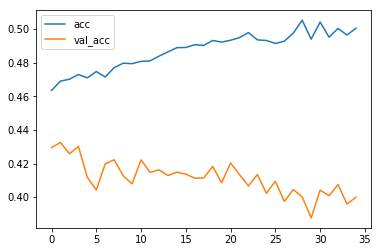

In [29]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

3


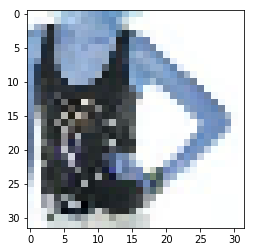

In [36]:
i = 4200
img = new_test_images_masked[i]
img2 = img[:,:,::-1]
plt.imshow(img2)
print(new_test_labels_masked[i])

In [37]:
new_X,new_y = shuffle(new_X,new_y)

In [38]:
X_t, X_tt, y_t, y_tt = train_test_split(new_X, new_y, test_size=0.33, random_state=42)

In [39]:
data = (X_t, y_t, X_tt, y_tt)

In [23]:
#data = (new_images_masked, new_labels_masked, new_test_images_masked, new_test_labels_masked)
#data = (nx_train,ny_train,nx_test,ny_test)

## Set hyperparameter and train model

In [41]:
'''
epochs = 20
batch_size = 512
learning_rate = 0.001
dropout_probs = 0.5

dense3 train = 0.9, test = 0.49
'''
epochs = 20
batch_size = 128
learning_rate = 0.005
dropout_probs = 0.5

In [42]:
#define the model
modell = ImageSearchModel(learning_rate, (32,32), 6)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 1/20  | Training accuracy: 0.18645608836206898  | Training Loss: 2.096726894378662


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Test accuracy: 0.19867050438596492



Epoch: 2/20  | Training accuracy: 0.24737338362068967  | Training Loss: 1.7262465953826904



Test accuracy: 0.26541940789473684



Epoch: 3/20  | Training accuracy: 0.31819100215517243  | Training Loss: 1.599303126335144



Test accuracy: 0.3374451754385965



Epoch: 4/20  | Training accuracy: 0.3543911637931034  | Training Loss: 1.5253347158432007



Test accuracy: 0.3712308114035088



Epoch: 5/20  | Training accuracy: 0.38671875  | Training Loss: 1.4825537204742432



Test accuracy: 0.38788377192982454



Epoch: 6/20  | Training accuracy: 0.4016029094827586  | Training Loss: 1.4569804668426514



Test accuracy: 0.40460526315789475



Epoch: 7/20  | Training accuracy: 0.41908001077586204  | Training Loss: 1.4315985441207886



Test accuracy: 0.41495339912280704



Epoch: 8/20  | Training accuracy: 0.4359846443965517  | Training Loss: 1.4018480777740479



Test accuracy: 0.41241776315789475



Epoch: 9/20  | Training accuracy: 0.4512728987068966  | Training Loss: 1.3786019086837769



Test accuracy: 0.39953399122807015



Epoch: 10/20  | Training accuracy: 0.4641029094827586  | Training Loss: 1.3527112007141113



Test accuracy: 0.4278371710526316



Epoch: 11/20  | Training accuracy: 0.4726899245689655  | Training Loss: 1.3316447734832764



Test accuracy: 0.4270833333333333



Epoch: 12/20  | Training accuracy: 0.4858903556034483  | Training Loss: 1.3074846267700195



Test accuracy: 0.4172834429824561



Epoch: 13/20  | Training accuracy: 0.4956896551724138  | Training Loss: 1.2860593795776367



Test accuracy: 0.4283168859649123



Epoch: 14/20  | Training accuracy: 0.5104054418103449  | Training Loss: 1.2557530403137207



Test accuracy: 0.43188048245614036



Epoch: 15/20  | Training accuracy: 0.5284886853448276  | Training Loss: 1.2212318181991577



Test accuracy: 0.4310581140350877



Epoch: 16/20  | Training accuracy: 0.5443830818965517  | Training Loss: 1.1848726272583008



Test accuracy: 0.42667214912280704



Epoch: 17/20  | Training accuracy: 0.5600417564655172  | Training Loss: 1.1570944786071777



Test accuracy: 0.4292077850877193



Epoch: 18/20  | Training accuracy: 0.5689991918103449  | Training Loss: 1.129606008529663



Test accuracy: 0.43530701754385964



Epoch: 19/20  | Training accuracy: 0.5787984913793104  | Training Loss: 1.1136999130249023



Test accuracy: 0.43277138157894735



Epoch: 20/20  | Training accuracy: 0.5836813038793104  | Training Loss: 1.1008111238479614



Test accuracy: 0.4296875


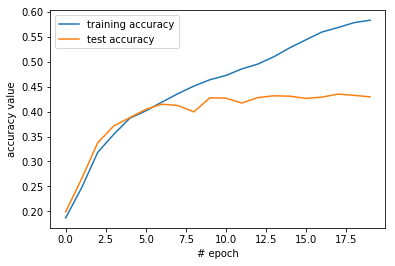

In [43]:
train(modell, epochs, dropout_probs, batch_size, data, 'saver')